In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
arima_df = pd.read_csv('preprocessed_model_data.csv')

In [3]:
arima_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh,Date
0,90001,Los Angeles County,1,2015,Residential,3872318.0,3.872318,2015-01-01
1,90001,Los Angeles County,1,2015,Commercial,4278310.0,4.278310,2015-01-01
2,90002,Los Angeles County,1,2015,Residential,1440786.0,1.440786,2015-01-01
3,90002,Los Angeles County,1,2015,Commercial,505206.0,0.505206,2015-01-01
4,90008,Los Angeles County,1,2015,Residential,439343.0,0.439343,2015-01-01


In [4]:
arima_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127151 entries, 0 to 127150
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ZipCode        127151 non-null  int64  
 1   County         127151 non-null  object 
 2   Month          127151 non-null  int64  
 3   Year           127151 non-null  int64  
 4   CustomerClass  127151 non-null  object 
 5   TotalkWh       127151 non-null  float64
 6   TotalGWh       127151 non-null  float64
 7   Date           127151 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 7.8+ MB


In [5]:
# Convert 'Date' from string to datetime type

arima_df['Date'] = pd.to_datetime(arima_df['Date'], format='%Y-%m-%d')

In [6]:
# Set Date as index

arima_df = arima_df.set_index('Date')

# Resample to total montly usage
arima_df  = arima_df[['TotalkWh','TotalGWh']].resample('M').sum()

### Finding optimal parameters

In [7]:
# libraries for parameter testing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# check for stationary data
def check_stationarity(timeseries):

    # perform Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Stastistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

check_stationarity(arima_df['TotalGWh'])

ADF Stastistic: -1.1219915544260948
p-value: 0.706222730570806
Non-Stationary


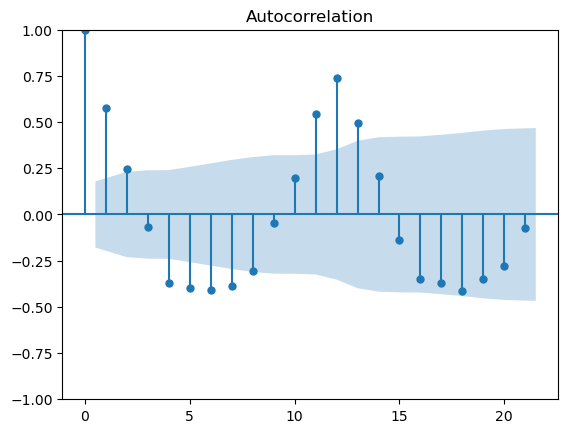

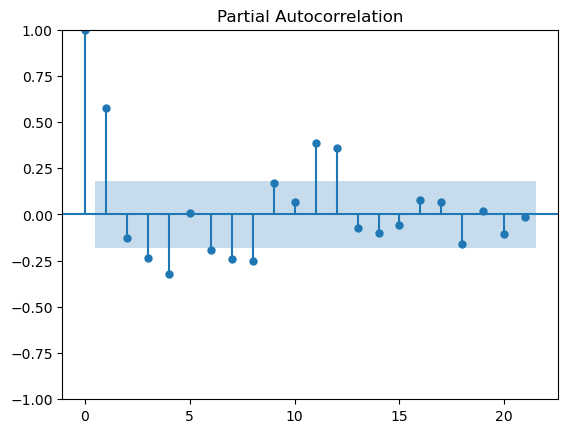

In [8]:
 # Plot ACF and PACF
plot_acf(arima_df['TotalGWh'])
plot_pacf(arima_df['TotalGWh'])
plt.show()

## Finding d value from Tuning Autocorrelation Tests

<function matplotlib.pyplot.show(close=None, block=None)>

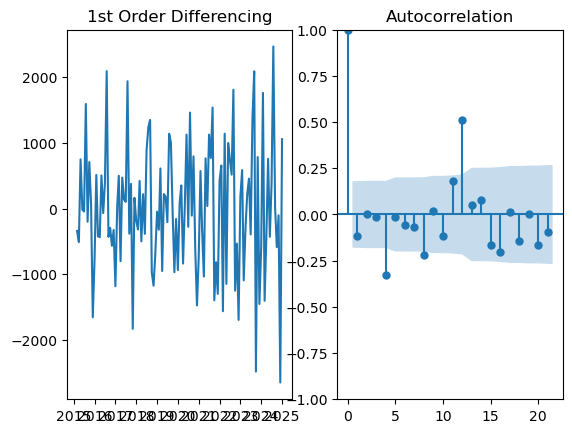

In [9]:
f= plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(arima_df.TotalGWh.diff())

ax2 = f.add_subplot(122)
plot_acf(arima_df.TotalGWh.diff().dropna(), ax=ax2)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

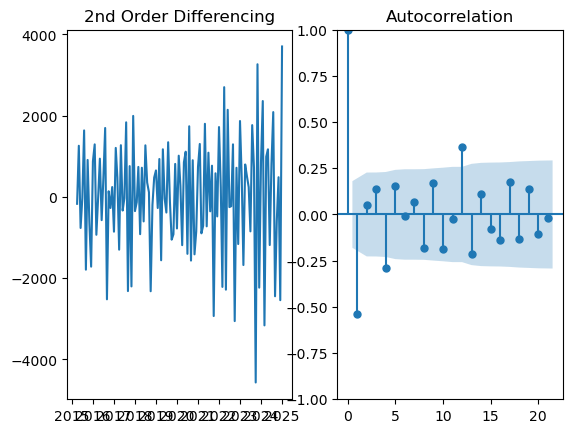

In [10]:
f= plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(arima_df.TotalGWh.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(arima_df.TotalGWh.diff().diff().dropna(), ax=ax2)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

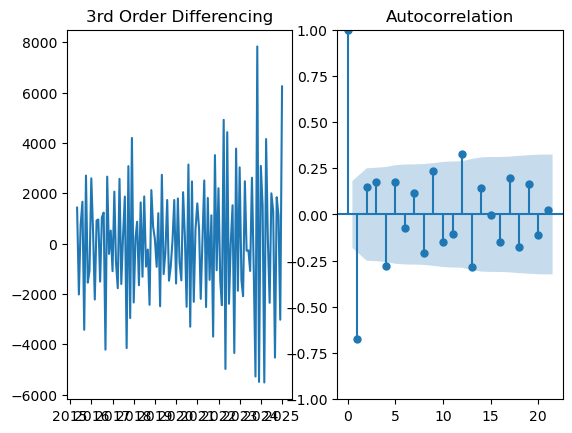

In [11]:
f= plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('3rd Order Differencing')
ax1.plot(arima_df.TotalGWh.diff().diff().diff())

ax2 = f.add_subplot(122)
plot_acf(arima_df.TotalGWh.diff().diff().diff().dropna(), ax=ax2)
plt.show

## Finding p value from Tuning Partial Autocorrelation Tests

<function matplotlib.pyplot.show(close=None, block=None)>

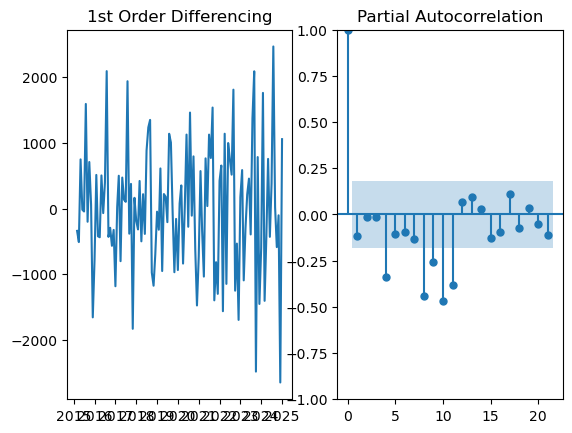

In [12]:
f= plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(arima_df.TotalGWh.diff())

ax2 = f.add_subplot(122)
plot_pacf(arima_df.TotalGWh.diff().dropna(), ax=ax2)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

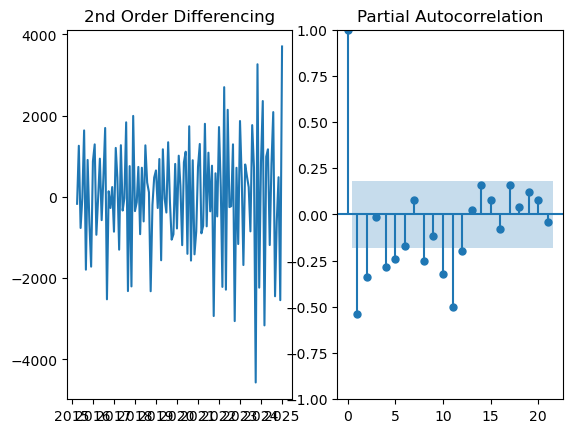

In [13]:
f= plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(arima_df.TotalGWh.diff().diff())

ax2 = f.add_subplot(122)
plot_pacf(arima_df.TotalGWh.diff().diff().dropna(), ax=ax2)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

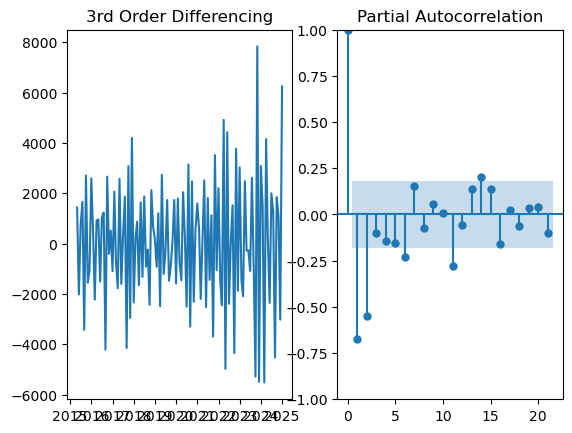

In [14]:
f= plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('3rd Order Differencing')
ax1.plot(arima_df.TotalGWh.diff().diff().diff())

ax2 = f.add_subplot(122)
plot_pacf(arima_df.TotalGWh.diff().diff().diff().dropna(), ax=ax2)
plt.show

## Testing range of values to find lowest AIC score for the best model

In [15]:
import itertools
from itertools import islice
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Set each hyperparameter to have values from 0-5

p = d = q = range(0,5)

# list of all possible ordered comibnations of p, d, q
pdq = list(itertools.product(p,d,q))

# set empty list to store AIC scores
aic_scores = []
# set empty dictionary to store hyperparameter combo and resulting AIC score
param_aic_dict = {}

# iterate through each hyperparameter combos to get resulting AIC scores and store them
for param in pdq:
    try:
        model_arima = ARIMA(arima_df.TotalGWh, order=param)
        model_arima_fit = model_arima.fit()
        print(param, model_arima_fit.aic) 
        # add AIC score to list
        aic_scores.append(model_arima_fit.aic)
        # add hyperparameter combo and resulting AIC score as key-value pairs
        param_aic_dict.update({param:model_arima_fit.aic})
    except:
        continue

# The Akaike Information Criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of statistical models
# for a given set of data
# Similar to mean squared error in Regression; smaller the value, the better.

(0, 0, 0) 2011.6830220444174
(0, 0, 1) 1972.4602584627878
(0, 0, 2) 1968.0190979224903
(0, 0, 3) 1955.039978234412
(0, 0, 4) 1954.5935218804702
(0, 1, 0) 1973.411113047866
(0, 1, 1) 1973.5882244940426
(0, 1, 2) 1975.3039773800185
(0, 1, 3) 1960.7944491164303
(0, 1, 4) 1945.6306853494639
(0, 2, 0) 2052.106644891517
(0, 2, 1) 1968.1891741006668
(0, 2, 2) 1969.6828740081003
(0, 2, 3) 1971.3859765907994
(0, 2, 4) 1963.0630412876146
(0, 3, 0) 2165.143119428752
(0, 3, 1) 2041.7016147457366
(0, 3, 2) 1963.405637884047
(0, 3, 3) 1963.0120757845948
(0, 3, 4) 1964.894762992872
(0, 4, 0) 2285.7783905021565
(0, 4, 1) 2152.5563458934535
(0, 4, 2) 2035.2416411045533
(0, 4, 3) 1958.934736732544
(0, 4, 4) 1960.6508920049757
(1, 0, 0) 1965.2181502615101
(1, 0, 1) 1966.2037937862563
(1, 0, 2) 1965.1025835712903
(1, 0, 3) 1969.8804362932683
(1, 0, 4) 1950.647015758586
(1, 1, 0) 1973.6305759761553
(1, 1, 1) 1955.4169087177168
(1, 1, 2) 1956.6956787678357
(1, 1, 3) 1956.04412801809
(1, 1, 4) 1946.984011388

In [17]:
# total number of AIC scores evaluated

len(aic_scores)

123

In [18]:
# finding lowest value in list

min(aic_scores)

1919.0774717157506

In [19]:
# Manual alternative

min_val = aic_scores[0]
for num in aic_scores:
    if num < min_val:
        min_val = num
        
print(min_val)

1919.0774717157506


In [20]:
# Print the first 5 hyperparameter combo : AIC score

for key, value in islice(param_aic_dict.items(), 5):
    print(f"{key}: {value}")

(0, 0, 0): 2011.6830220444174
(0, 0, 1): 1972.4602584627878
(0, 0, 2): 1968.0190979224903
(0, 0, 3): 1955.039978234412
(0, 0, 4): 1954.5935218804702


In [21]:
# Store lowest aic score

best_aic = min(aic_scores)


# Define function to get the best hyperparameter combo
def get_param_from_aic(param_aic_dict, best_aic):
    """
    Returns the first hyperparameter in the dictionary that maps to the best AIC.
    Returns None if the value is not found.
    """
    for param, aic in param_aic_dict.items():
        if aic == best_aic:

            # returns a tuple
            return param
    return None


# Map best aic score to its associated hyperparameters
best_param = get_param_from_aic(param_aic_dict, best_aic)

print(f"Based on the evaluation of AIC scores, the best hyperparameter (p,d,q) combination is {best_param}.")

Based on the evaluation of AIC scores, the best hyperparameter (p,d,q) combination is (2, 0, 3).


- Based on lowest AIC score, the p,d,q combination of **(2,0,3)** is the best performing ARIMA model

### Create and Fit ARIMA model

In [22]:
# set order to the 'best_param' tuple
arima_model = ARIMA(arima_df.TotalGWh, order=best_param)
model_arima = arima_model.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:               TotalGWh   No. Observations:                  120
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -952.539
Date:                Sat, 30 Aug 2025   AIC                           1919.077
Time:                        12:24:34   BIC                           1938.590
Sample:                    01-31-2015   HQIC                          1927.002
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6685.7981     76.282     87.646      0.000    6536.288    6835.308
ar.L1          1.7303      0.004    392.681      0.000       1.722       1.739
ar.L2         -1.0000      0.000  -4571.959      0.0

In [23]:
# Calculate the mean absolute error from residuals

mae = np.mean(np.abs(model_arima.resid))

# Print mean absolute error

print('MAE: %.3f' % mae)

MAE: 508.611


### Forecasting the next 12 months

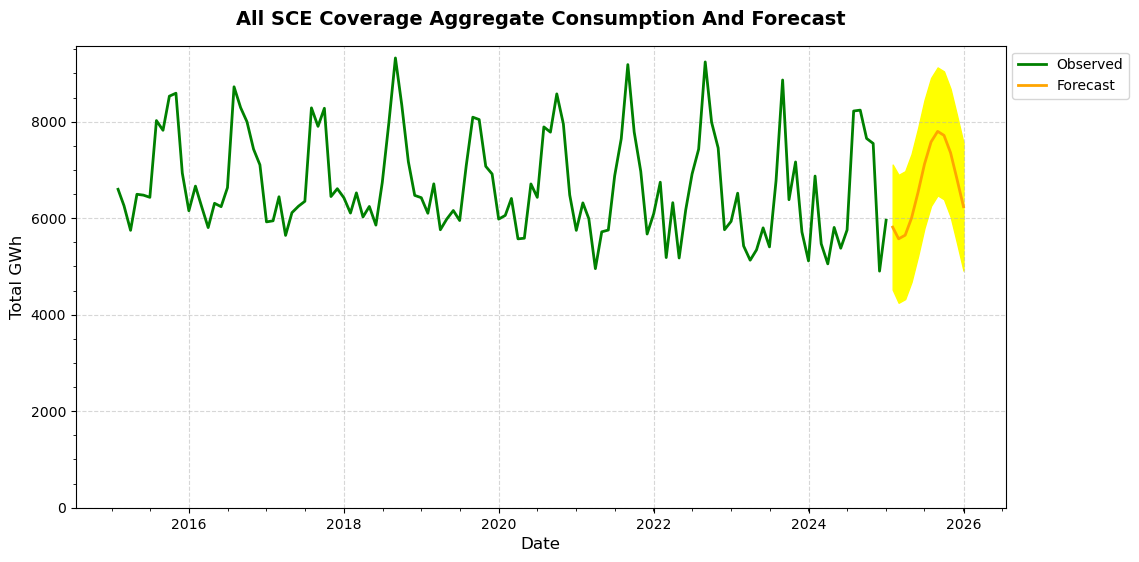

In [24]:
from matplotlib.ticker import AutoMinorLocator

# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = model_arima.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot settings
plt.figure(figsize=(12, 6))
ax1 = sns.lineplot(data=arima_df['TotalGWh'], label='Observed', linewidth=2, color='green')
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='orange', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='yellow')


# Plot labels and legend
plt.title("All SCE Coverage Aggregate Consumption And Forecast", weight='bold', fontsize=14,pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.14, 1), loc='upper right')

# Show plot
#plt.savefig('all_sce_forecast.png')
plt.show()

### Evaluate Model

In [25]:
observed = arima_df['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 667.7405926186716
MSE: 760357.846335977
RMSE: 871.9850035040608


In [26]:
observed

Date
2024-01-31    6874.243089
2024-02-29    5469.841570
2024-03-31    5054.460759
2024-04-30    5809.234366
2024-05-31    5378.588026
2024-06-30    5757.200322
2024-07-31    8222.266194
2024-08-31    8240.649850
2024-09-30    7653.551659
2024-10-31    7550.048888
2024-11-30    4903.567180
2024-12-31    5958.640238
Freq: M, Name: TotalGWh, dtype: float64

In [27]:
forecast_mean

2025-01-31    5815.543420
2025-02-28    5573.041521
2025-03-31    5649.120869
2025-04-30    6004.803529
2025-05-31    6544.156560
2025-06-30    7121.709468
2025-07-31    7581.689478
2025-08-31    7800.035274
2025-09-30    7717.857606
2025-10-31    7357.322097
2025-11-30    6815.670547
2025-12-31    6238.993378
Freq: M, Name: predicted_mean, dtype: float64